In [1]:
!pip install d2l

In [2]:
import torch
from d2l import torch as d2l
from sklearn.preprocessing import StandardScaler
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from IPython import display
from torch.utils import data
import torch.optim as optim

In [3]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (3).csv
Saving train.csv to train (3).csv


In [4]:
#读取前五行
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

#合并训练集和测试集
combined_df = pd.concat([train_df, test_df], ignore_index=True)

In [5]:
#处理Pclass
combined_df = pd.get_dummies(combined_df, columns=['Pclass'], drop_first=False)

In [6]:
combined_df['Pclass_1'] = combined_df['Pclass_1'].astype('int64')
combined_df['Pclass_2'] = combined_df['Pclass_2'].astype('int64')
combined_df['Pclass_3'] = combined_df['Pclass_3'].astype('int64')

In [7]:
#处理Sex
combined_df = pd.get_dummies(combined_df, columns=['Sex'], drop_first=False)

In [8]:
combined_df['Sex_female'] = combined_df['Sex_female'].astype('int64')
combined_df['Sex_male'] = combined_df['Sex_male'].astype('int64')

In [9]:
#处理Age，用中位数填充缺失值
combined_df['Age'].fillna(combined_df['Age'].median(), inplace=True) #表示直接修改原数据中的缺失值

In [10]:
combined_df['Age'] = StandardScaler().fit_transform(combined_df[['Age']])

In [11]:
#标准化SibSp
combined_df['SibSp'] = StandardScaler().fit_transform(combined_df[['SibSp']])

In [12]:
#标准化Parch
combined_df['Parch'] = StandardScaler().fit_transform(combined_df[['Parch']])

In [13]:
#标准化Fare
combined_df['Fare'] = StandardScaler().fit_transform(combined_df[['Fare']])

In [14]:
#处理Embarked
combined_df = pd.get_dummies(combined_df, columns=['Embarked'], drop_first=False)

In [15]:
combined_df['Embarked_C'] = combined_df['Embarked_C'].astype('int64')
combined_df['Embarked_Q'] = combined_df['Embarked_Q'].astype('int64')
combined_df['Embarked_S'] = combined_df['Embarked_S'].astype('int64')

In [16]:
print(combined_df.dtypes)

PassengerId      int64
Survived       float64
Name            object
Age            float64
SibSp          float64
Parch          float64
Ticket          object
Fare           float64
Cabin           object
Pclass_1         int64
Pclass_2         int64
Pclass_3         int64
Sex_female       int64
Sex_male         int64
Embarked_C       int64
Embarked_Q       int64
Embarked_S       int64
dtype: object


In [17]:
#拆分回训练集和测试集
train_size = train_df.shape[0]
test_size = test_df.shape[0]
print(train_size, test_size)

train_df = combined_df.iloc[:train_size]
test_df = combined_df.iloc[train_size:]
print(train_df.head())

891 418
   PassengerId  Survived                                               Name  \
0            1       0.0                            Braund, Mr. Owen Harris   
1            2       1.0  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2            3       1.0                             Heikkinen, Miss. Laina   
3            4       1.0       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4            5       0.0                           Allen, Mr. William Henry   

        Age     SibSp  Parch            Ticket      Fare Cabin  Pclass_1  \
0 -0.581628  0.481288 -0.445         A/5 21171 -0.503402   NaN         0   
1  0.658652  0.481288 -0.445          PC 17599  0.734222   C85         1   
2 -0.271558 -0.479087 -0.445  STON/O2. 3101282 -0.490356   NaN         0   
3  0.426099  0.481288 -0.445            113803  0.382778  C123         1   
4  0.426099 -0.479087 -0.445            373450 -0.487940   NaN         0   

   Pclass_2  Pclass_3  Sex_female  Sex_male  Embarked_C  Emb

In [18]:
# 提取特征和目标变量
X_train = train_df.drop(columns=['PassengerId', 'Survived', 'Survived', 'Name', 'Ticket', 'Cabin'])  # 特征数据
y_train = train_df['Survived']  # 目标标签

X_test = test_df.drop(columns=['PassengerId', 'Survived', 'Survived', 'Name', 'Ticket', 'Cabin'])

print(X_train.head())

        Age     SibSp  Parch      Fare  Pclass_1  Pclass_2  Pclass_3  \
0 -0.581628  0.481288 -0.445 -0.503402         0         0         1   
1  0.658652  0.481288 -0.445  0.734222         1         0         0   
2 -0.271558 -0.479087 -0.445 -0.490356         0         0         1   
3  0.426099  0.481288 -0.445  0.382778         1         0         0   
4  0.426099 -0.479087 -0.445 -0.487940         0         0         1   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0           0         1           0           0           1  
1           1         0           1           0           0  
2           1         0           0           0           1  
3           1         0           0           0           1  
4           0         1           0           0           1  


In [19]:
print(X_train.shape, y_train.shape)

(891, 12) (891,)


In [20]:
#将数据转化为张量
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

In [21]:
len(X_test_tensor)

418

In [22]:
#把X和y存储到train_dataset中
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

In [23]:
print(X_train_tensor.shape, y_train_tensor.shape)

torch.Size([891, 12]) torch.Size([891])


In [24]:
#使用内置的数据迭代器读取小批量参数
batch_size = 33

def get_dataloader_workers():
    #使用4个进程来读取数据
    return 4

train_iter = data.DataLoader(train_dataset, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


torch.Size([33, 12]) torch.float32 torch.Size([33]) torch.float32


In [55]:
#初始化参数
W = torch.normal(0.5, 0.01, size=(X_train_tensor.shape[1], 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [50]:
#定义操作sigmoid
def sigmoid(X):
  return 1 / (1 + torch.exp(-X))

In [51]:
#定义模型
def net(X):
  return sigmoid(torch.matmul(X, W) + b).squeeze()

In [52]:
#定义损失函数
loss = nn.BCELoss()

In [29]:
#预测正确的数量
def accuracy(y_hat, y, threshold=0.45):
  correct = 0
  # Loop through each sample
  for i in range(len(y_hat)):
    # Assuming y_hat is a 1D tensor with shape (N,)
    if y_hat[i] >= threshold:
      predicted = 1
    else:
      predicted = 0
    # Compare predicted and true labels
    if predicted == y[i].item():  # Convert y[i] to a scalar if needed
      correct += 1
  return correct

In [30]:
#Accumulator的实现
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [31]:
#辅助函数，动画化训练过程
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:  #没有图例
            legend = []
        d2l.use_svg_display() #显示图形的svg函数，使图像高质量显示
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)  #创建一个模型和多个子图
        if nrows * ncols == 1:   #如果图形只有1个子图
            self.axes = [self.axes, ]  #把它转换为包含单个元素的列表
        # 配置坐标轴，定义了一个 lambda 函数 self.config_axes，用于设置坐标轴的标签、范围、刻度类型和图例
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0] #应用于当前坐标轴
            , xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"): #y如果不是列表
            y = [y] #把y转换为列表
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n  #把x转换为长度为n的列表
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]  #初始化为包含n个空列表的列表
        for i, (a, b) in enumerate(zip(x, y)):  #把每一组数据点（a，b）添加到（x，y）中
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()  #清空当前图表
        for x, y, fmt in zip(self.X, self.Y, self.fmts): #遍历x，y，在图表上绘制相对应的线条
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig) #显示更新后的图形
        display.clear_output(wait=True)  #清除之前的图形输出

In [32]:
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):  #判断该模型是否为pytorch的模型
        net.train()  #转化为训练模型
    metric = Accumulator(3)  #长度为3的迭代器
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer): #检查updater是不是pytorch中的优化器对象
            updater.zero_grad() #初始化梯度
            l.backward() #前向传播求导
            updater.step() #更新梯度参数
            metric.add(
                float(l.sum()), accuracy(y_hat, y),
                y.size().numel())
        else:   #该模型为手动定义的模型
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.size().numel())
    return metric[0] / metric[2], metric[1] / metric[2]

In [33]:
def train_ch3(net, train_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.01, 0.9],
                        legend=['train loss', 'train acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater) #计算训练误差
        animator.add(epoch + 1, train_metrics) #每次迭代的训练误差
        train_loss, train_acc = train_metrics

In [56]:
#用小批量梯度下降来优化模型的损失函数
lr = 0.6

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

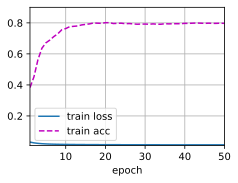

In [57]:
num_epochs = 50
train_ch3(net, train_iter, loss, num_epochs, updater)

In [61]:
# prompt: 使用最新更新的net生成y_test_tensor
y_test = net(X_test_tensor)
y_test_labels = (y_test > 0.5).float()

print("Predicted y_test labels:", y_test_labels)

Predicted y_test labels: tensor([0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
        1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
        1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.,
        1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1.,
        0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
        1., 0.,